<a href="https://colab.research.google.com/github/Jalapinho1/Deep-Reinforcement-Learning-Explained/blob/main/RFL_MCControl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MC Control implementation

Implementation of constant-𝛼 MC control that can help an Agent recover the optimal policy the Blackjack Environment.

In [3]:
import sys
import gym
import numpy as np
from collections import defaultdict

Here, instead of being the policy hardcoded by the programmer, the MC Control algorithm will estimate and return an optimal policy, together with the Q-table:

In [ ]:
env = gym.make('Blackjack-v0')
num_episodes=1000000
alpha = 0.02
eps_decay=.9999965
gamma=1.0

# policy, Q = MC_control(env, num_episodes, alpha, eps_decay, gamma)

Specifically, policy is a dictionary whose key corresponds to a states (a 3-tuple indicating the player’s current sum, the dealer’s face-up card, and whether or not the player has a usable ace) and the value of the corresponding entry indicates the action that the Agent chooses after observing this state following this policy.

Remember that the other dictionary returned by the function, the Q-tableQ, is a dictionary where the key of a given entry in the dictionary corresponds to a states and the value of the corresponding entry contains an array of dimension equal to the number of actions (2 dimensions in our case) where each element contains the estimated action-value for each action.

As input this MC Control algorithm has the following arguments:
* env: The instance of an OpenAI Gym Environment.
* num_episodes: The number of episodes that are generated.
* alpha: The step-size parameter for the update step.
* eps_decay: The decay factor for the update of the * epsilon parameter.
* gamma: The discount rate.

**Setting the Value of Epsilon**

Before starting to program, a code based on the previously presented pseudocode takes a moment to see how we modify the value of ϵ , making it gradually decay when specifying an ϵ-greedy policy. Remember that this is important to guarantee that MC control converges to the optimal policy π∗​.

With the following code that sets the value for ϵ in each episode and monitor its evolutions with a print we can check that selecting an eps_decay=0.9999965 we can obtain the gradual decay of ϵ:

In [4]:
num_episodes=1000000

eps_start=1.0 
eps_decay=.9999965
eps_min=0.05

epsilon = eps_start
for episode in range(num_episodes):
        epsilon = max(epsilon*eps_decay, eps_min)
        if episode % 100000 == 0: print("Episode {} -> epsilon={}.".format(episode, epsilon))

Episode 0 -> epsilon=0.9999965.
Episode 100000 -> epsilon=0.7046851916863968.
Episode 200000 -> epsilon=0.4965829574224525.
Episode 300000 -> epsilon=0.3499358813150294.
Episode 400000 -> epsilon=0.24659549668667013.
Episode 500000 -> epsilon=0.17377280305645773.
Episode 600000 -> epsilon=0.12245554962615056.
Episode 700000 -> epsilon=0.08629291448656881.
Episode 800000 -> epsilon=0.060809551819579116.
Episode 900000 -> epsilon=0.05.


**Main function**

The first thing, following the pseudocode, is to initialize all the values in the Q-table to zero. So Qis initialized to an empty dictionary of arrays with the total number of actions that are in the Environment:



```
nA = env.action_space.n
Q = defaultdict(lambda: np.zeros(nA)
```

After that, we loop num_episodesover episodes, and then with each episode we compute the corresponding ϵ, construct the corresponding ϵ-greedy policy with respect to the most recent estimate of the Q-table, and then generate an episode using that ϵ-greedy policy. Finally, we update the Q-table using the update equation presented before:

```
for episode in range(1, num_episodes+1):
       epsilon = max(epsilon*eps_decay, eps_min)
       episode_generated=generate_episode_from_Q(env,Q,epsilon,nA)
       Q = update_Q(env, episode_generated, Q, alpha, gamma)
```

After finishing the loop of episodes, the policy corresponding to the final Q-table is calculated with the following code:

```
policy=dict((state,np.argmax(actions)) \ 
            for state, actions in Q.items())
```

That is, the policy indicates for each state which action to take, which just corresponds to the action that has the maximum action-value in the Q-table.

**Generate episodes using Q-table and epsilon-greedy policy**

The construction of the corresponding ϵ-greedy policy and the generation of an episode using this ϵ-greedy policy are wrapped up in the generate_episode_from_Q function

This function takes as input the Environment, the most recent estimate of the Q-table, the value of current Epsilon and the number of actions. As an output, it returns an episode.

The Agent will use the Epsilon-greedy policy to select actions. We have implemented that using the *random.choice* method from Numpy, which takes as input the set of possible actions and the probabilities corresponding to the Epsilon greedy policy. The obtention of the action probabilities corresponding to ϵ-greedy policy will be done using this code:

In [7]:
def get_probs(Q_s, epsilon, nA):
    policy_s = np.ones(nA) * epsilon / nA
    max_action = np.argmax(Q_s)
    policy_s[max_action] = 1 - epsilon + (epsilon / nA)
    return policy_s

If you take a look at *get_probs* function code, it implements the epsilon-greedy policy detailed in the previous section.

Obviously, if the state is not already in Q-table, we randomly choose one action using the *action_space.sample()*. The complete code for this function that generates an episode following the epsilon-greedy policy is coded as follows:

In [6]:
def generate_episode_from_Q(env, Q, epsilon, nA):
    episode = []
    state = env.reset()
    while True:
          probs = get_probs(Q[state], epsilon, nA)
          action = np.random.choice(np.arange(nA), p=probs)     \
                   if state in Q else env.action_space.sample()
          next_state, reward, done, info = env.step(action) 
          episode.append((state, action, reward))
          state = next_state
          if done:
             break
    return episode

**Update Q-table**

Once we have the episode we just look at each state-action and we apply the update equation:

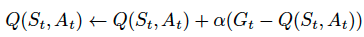

The code that programs this equation is


In [8]:
def update_Q(env, episode, Q, alpha, gamma):
    
    states, actions, rewards = zip(*episode)

    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [9]:
def MC_control(env, num_episodes, alpha, eps_decay, gamma):
    eps_start=1.0
    eps_min=0.05

    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))

    epsilon = eps_start
    
    for episode in range(1, num_episodes+1):
        
        if episode % 1000 == 0: # monitor progress
            print("\rEpisode {}/{}.".format(episode, num_episodes), end="")
            sys.stdout.flush()

        epsilon = max(epsilon*eps_decay, eps_min)
        episode_generated = generate_episode_from_Q(env, Q, epsilon, nA)
        Q = update_Q(env, episode_generated, Q, alpha, gamma)
    policy = dict((state,np.argmax(actions)) for state, actions in Q.items())
    return policy, Q

In [10]:
policy, Q = MC_control(env, num_episodes, alpha, eps_decay, gamma)

Episode 1000000/1000000.

**Plot state-value function**

As in the example of the previous post, we can obtain the corresponding estimated optimal state-value function and plot it:

With a simple visual analysis of the graphs of this post and those of the previous post, we can see that the policy obtained with the MC Control presented here is better since the state-value values are much higher.

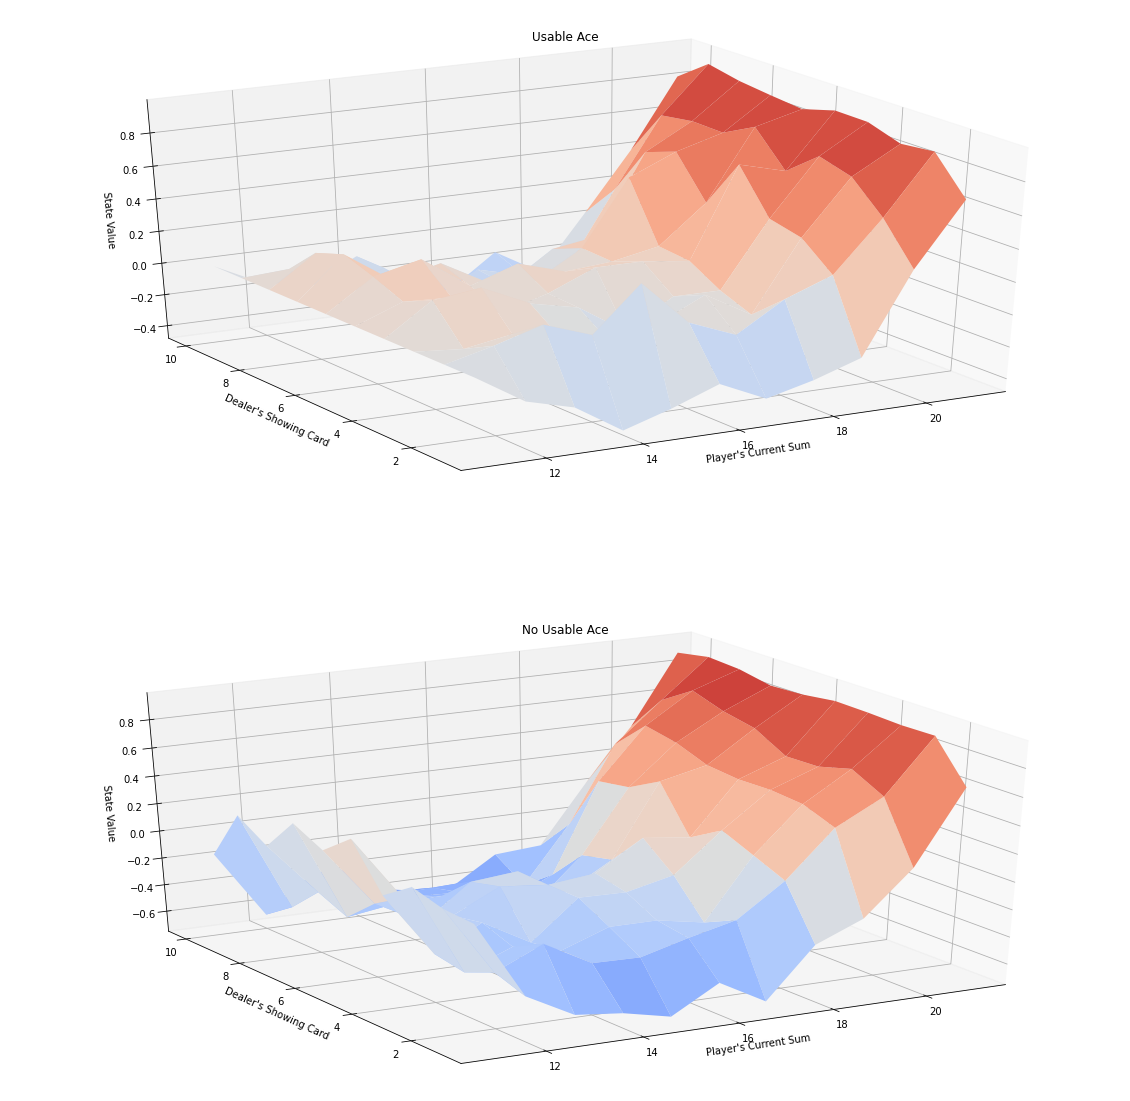

In [13]:
V = dict((state,np.max(actions)) for state, actions in Q.items())

plot_blackjack_values(V)

In [12]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()